In [1]:
# This Jupyter notebook is for generating figures for Fan et al. 2024

from scipy.optimize import fsolve, root
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline

def main_func(So = 1360, Fo = 0, epsl0 = 0.5, a0 = 0, 
                LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', overshoot = '0N2', 
                daycloud = 'default', nightcloud = 'default', 
                vaporlimit = 500,
                T_run = 270, T_end = 850, deltaT_off = -30, 
                kappa_SW = 2.5e-2, F_NC = 110, k3 = 0.08,
                T_ideal = 270, k_ideal = 1,
                p_guess=(250,250,200,200,200,20), output = 'default'):
    
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # epsl0: atmospheric emissivity (for the LW == 'constant' case)
    # a0: atmospheric SW absorptivity (for the SW == 'constant' case)
    # assumption varies, the default assumption is Yang et al. 2014 model
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa
    R_star = 8.3145         # universal gas constant
    k1 = 0.2                # fraction of heat transport to the nightside deposited in the boundary layer
    k2 = 5000               # relates water vapor to the infrared opacity
#     k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8         # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                # cloud emission temperature (FAT)
#     kappa_SW = 5e-3 * 5       # shortwave opacity
#     T_run = 270             # emission temperature for the runaway greenhouse

    ### Constants for water vapor calculations    
    RH1 = 0.9           # Dayside surface relative humidity
    RH2 = 0.8           # Dayside atmosphere relative humidity
    RH3 = 0.3           # Nightside atmosphere relative humidity
    es0 = 611.2         # reference pressure for CC relation
    M = 0.018           # molar mass of water vapor
    mm_dry = 0.028      # molar mass of dry air
    mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
    L = 2.501e6                 # latent heat of vaporization in J/kg
    To = 273.15                 # reference temperature for CC relation

    Cpd = 1005.7                # heat capacity of dry air in J/kg/K
    Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        
    def alpha(fc):
        alpha_p = 0.09 + fc - 0.09*fc
        return alpha_p
    
    def cld_frc(Fc):
        if daycloud == 'no cloud':
            return 0
        elif daycloud == 'fixed':
            return 0.3
        else:
            if Fc <= 0:                    # cloud fraction should always be positive
                fc = 0
            else:
                fc = k3 * np.log(Fc+1.0)     # expression of cloud fraction versus convection
                fc = min(fc, 1)            # fix the unrealistic case when we get cloud fraction larger than 1
            return fc

    def F_cloud(T):   # A function to include the nightside cloud effect
        if nightcloud =='transition':
            if T < 320:
                return 0
            elif T < 400:
                return F_NC * 7/11 / 80 * (T - 320)  # Slope = 70 / (400-320)
            elif T < 700:
                return F_NC * 7/11
            elif T < 800:
                return F_NC * 7/11 + F_NC * 4/11 / 100 * (T - 700)  # Slope = 40 / (800-700)
            else:
                return F_NC
        else:
            return 0
        
    def Tv(T, mass_ratio, w):               # virtual temperature, w is the water vapor mixing ratio
        return T * (1 + w/mass_ratio) / (1 + w)

    def CC(T):     
        if T <= 0:
            es = 0
        elif T > vaporlimit:
            es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/vaporlimit)) # saturation vapor pressure
        else:
            es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
#         if es > vaporlimit:
#             es = vaporlimit
#         elif T > 400:
#             if TOA == 'runaway':
#                 es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/400)) 
# #                 raise ValueError("Error, inconsistent water vapor calculations.")
#             else:
#                 es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T))
        return es
            
    def sp(T, Pd, RH):
        es = CC(T)
#         if T > 100 and T < 400:
#             es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
#         else:
#             es = 1e6
        qs = mass_ratio*es/(Pd + mass_ratio * es)     # sat. specific humidity, including additional vapor pressure
        q = RH * qs                                   # specific humidity
        return q, qs
    
    def a(T, q):
        if SW == 'constant':
            a = a0
        elif SW == 'feedback':
            e = CC(T)
#             if T > 100 and T < 400:
#                 e = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
#             else:
#                 e = 1e6
            k_SW = kappa_SW * (Pc + e) / g
#             k_SW = kappa_SW * (Pc) / g
            a = 1 - np.exp(-k_SW * q)
        return a

    def epsl(T, q):    # clear sky water vapor emissivity
        if LW == 'constant':
            epsl = epsl0
        elif LW == 'Yang2014':
            epsl = 1 - np.exp(-k2*q)  
        elif LW == 'feedback':
            e = CC(T)
#             if T > 100 and T < 400:
#                 e = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T)) # saturation vapor pressure
#             else:
#                 e = 1e6
            kappa_LW = k2 * g / Pc
            k_LW = kappa_LW * (Pc + e) / g
            epsl = 1 - np.exp(-k_LW * q)
        return epsl
    

    def OLR(Ta, emis):
        OLR =  emis * sigma * Ta ** 4
        if TOA == 'Yang2014':
            return OLR
        else:      # you need to read a Transmission data (Ts0 and Trans0) first for this option!
            if TOA == 'ideal':
                slope = 3
                OLR_ref = emis * sigma * T_run ** 4
                if Ta < T_run:
                    OLR = OLR_ref - slope * (T_run - Ta)
                elif Ta > T_end:
                    OLR = OLR_ref + slope * (Ta - T_end)
                else:
                    OLR = OLR_ref
                return OLR
            if TOA == 'ideal runaway':
                slope = 3
                OLR_ref = emis * sigma * T_run ** 4
                if Ta > T_run and Ta < T_end:
                    OLR = OLR_ref 
                elif Ta > T_end:
                    OLR = OLR_ref + slope * (Ta - T_end)
                return OLR
            if overshoot == '0N2':
                Trans = np.interp(Ta, Ts0+deltaT_off, Trans0)
                OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
            elif overshoot == '0.1N2':
                Trans = np.interp(Ta, Ts0-15, Trans0)
                OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
            else:
                Trans = np.interp(Ta, Ts0, Trans0)
                OLR = Trans * OLR + (1-Trans) * sigma * T_run ** 4
            if TOA == 'transition':
                return OLR
            elif TOA == 'runaway':
                if Ta > T_end:
                    OLR = OLR + (1-Trans) * 5.67e-3*(Ta-T_end)**2
                return OLR
    
    def check_MSE(T1, T2):
        q1, q1_s = sp(T1, Po, RH1)
        q2, q2_s = sp(T2, Pc, RH2)      
        Cp1 = Cpd*(1 - q1) + Cpv * q1  
        Cp2 = Cpd*(1 - q2) + Cpv * q2
        mm = mm_dry*(1 - q2) + M * q2
        P1 = Po + RH1 * CC(T1)
        P2 = Pc + RH2 * CC(T2)
 
        Z_a = np.log(P1/P2)*((R_star/mm)*T2)/g       
        if Cp1*T1 + L*q1 - (Cp2*T2 + L*q2_s + g*Z_a) >= 0:  
            return 0     # convective atmosphere
        else:
            return 1     # stable atmosphere
        
    def equations(p):  # Define the equations to solve
        #print('solving or calculating ...')
        if solve_index == 0:             # RCE case
            T1, T2, T3, T4, Fa, Fc = p  
        elif solve_index == 1:           # RE case
            T1, T2, T3, T4, Fa = p
            Fc = 0
        
        # water vapor calculations for dayside surface
        q1, q1_s = sp(T1, Po, RH1)
        # water vapor calcaulations for dayside atmosphere
        q2, q2_s = sp(T2, Pc, RH2)
        # water vapor calculations for nightside atmosphere
        q3, q3_s = sp(T3, Pc, RH3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        mm = mm_dry*(1 - q2) + M * q2
        
        H = ((R_star/mm)*T2)/g  # scale height of dayside atmosphere* (needs double-check for steam atmos)
        P1 = Po + RH1 * CC(T1)
        P2 = Pc + RH2 * CC(T2)
        Z_a = np.log(P1/P2)*H       # convection height* (needs double-check for steam atmos)
        
        # dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha(cld_frc(Fc)))*(1-a(T2, q2)) - Fc - Fo + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T2**4 + cld_frc(Fc)*sigma*Tc**4 - sigma*T1**4

        # dayside atmos energy equation
#         Eq3 = (1/2)*So*(1-alpha(cld_frc(Fc)))*a(T2, q2) + Fc - Fa + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T1**4 + cld_frc(Fc)*sigma*T1**4 - (1-cld_frc(Fc))*(epsl(T2, q2)*sigma*T2**4 + OLR(T2, epsl(T2, q2))) - 2*cld_frc(Fc)*sigma*Tc**4
        
#         Eq4 = Fa - Fd + epsl(T3, q3)*sigma*T4**4 - epsl(T3, q3)*sigma*T3**4 - (OLR(T3, epsl(T3, q3))-F_cloud(T4))

        Eq3 = (1/2)*So*(1-alpha(cld_frc(Fc)))*a(T2, q2) + Fc - Fa + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T1**4 + cld_frc(Fc)*sigma*T1**4 - (1-cld_frc(Fc))*(epsl(T2, q2)*sigma*T2**4 + (1-cld_frc(Fc)) * OLR(T2, epsl(T2, q2))) - 2*cld_frc(Fc)*sigma*Tc**4
        
        Eq4 = Fa - Fd + epsl(T3, q3)*sigma*T4**4 - epsl(T3, q3)*sigma*T3**4 - (OLR(T3, epsl(T3, q3))-F_cloud(T4))
        
        Eq5 = Fo + Fd + epsl(T3, q3)*sigma*T3**4 - sigma*T4**4
        
        Eq6 = T2 - T3      # weak temperature gradient assumption

        Eq7 = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature

        # calculation for other outputs
        epsl_2 = epsl(T2, q2)
        epsl_3 = epsl(T3, q3)
        
        Flux1 = (1/2)*So*(1-alpha(cld_frc(Fc)))*(1-a(T2, q2)) - Fc - Fo + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T2**4 + cld_frc(Fc)*sigma*Tc**4 - sigma*T1**4    # dayside surface LW emission into space
        Flux2 = (1/2)*So*(1-alpha(cld_frc(Fc)))*a(T2, q2) + Fc - Fa + (1-cld_frc(Fc))*epsl(T2, q2)*sigma*T1**4 + cld_frc(Fc)*sigma*T1**4 - (1-cld_frc(Fc))*(epsl(T2, q2)*sigma*T2**4 + OLR(T2, epsl(T2, q2))) - 2*cld_frc(Fc)*sigma*Tc**4
        Flux3 = Fa - Fd + epsl(T3, q3)*sigma*T4**4 - epsl(T3, q3)*sigma*T3**4 - OLR(T3, epsl(T3, q3))
        Flux4 = Fo + Fd + epsl(T3, q3)*sigma*T3**4 - sigma*T4**4                             
        
        fc = cld_frc(Fc)                           # cloud fraction
        alpha_p = alpha(cld_frc(Fc))               # planetary albedo 
        a_2 = a(T2, q2)                            # shortwave absorption coefficient
        alpha_b = (1-alpha(cld_frc(Fc)))*(1-a(T2, q2))   # Bond albedo? (assuming reflection is after absorption)
        FluxC = - (fc * (Flux1 + Flux2) - fc * sigma*Tc**4)    # net cloud radiative effect
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsl(T2, q2))*(1-fc)*sigma*T1**4 + (1-fc)*OLR(T2, epsl_2)
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsl(T3, q3))*sigma*T4**4 + OLR(T3,epsl_3)
        
        if output_index == 0:            
            if solve_index==0:
                return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
            elif solve_index==1:
                return (Eq2, Eq3, Eq4, Eq5, Eq6)
        elif output_index==1:
            return(fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC)
        
    # Solve the equations using fsolve function
    output_index = 0
    
    # two-step calculations
    if p_guess[5] != 0:           # RCE case
        solve_index = 0
        (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
        if Fc <= 0:               # stable atmosphere, switch to RE
            solve_index = 1       
            new_p_guess = p_guess[:5]
            Fc = 0
            (T1, T2, T3, T4, Fa), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
            if check_MSE(T1, T2) == 0:   # convection is going to happen, either case does not work
                ier = 0             # no possible solution
                solve_index = 0     # switch back to RCE
    else:   # if RE, no convection
        solve_index = 1
        new_p_guess = p_guess[:5]
        Fc = 0
        (T1, T2, T3, T4, Fa), info, ier, msg = fsolve(equations, new_p_guess, full_output=True)
        if check_MSE(T1, T2) == 0:   # convection is going to happen, switch to RCE
            solve_index = 0
            (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
            if Fc <= 0:             # stable atmosphere, either case does not work
                ier = 0             # no possible solution
                Fc = 0
                solve_index = 1     # switch back to RE
    
    
#     if ier==1:  # a solution is found
#         print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
#         Es = T1**4 + T4**4
#         Ea = T2**4 + T3**4 
#         print('The average atmosphere-surface energy ratio is:', (Ea/Es))
#         print('\n')
    
    # Extract the additional terms
    output_index = 1
    if solve_index == 0:
        fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC = equations((T1, T2, T3, T4, Fa, Fc))
    elif solve_index == 1:
        fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC = equations((T1, T2, T3, T4, Fa))
    
    outputs = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4, 'Fa': Fa, 'Fc': Fc, 'fc': fc,
               'q1': q1, 'q2': q2, 'q3': q3, 'alpha_p': alpha_p, 'alpha_b': alpha_b, 'epsl_2': epsl_2,
               'epsl_3': epsl_3, 'a_2': a_2, 'OLR_day': OLR_day, 'OLR_night': OLR_night,
               'Flux1': Flux1, 'Flux2': Flux2, 'Flux3': Flux3, 'Flux4': Flux4, 'FluxC': FluxC,
               'info': info, 'ier': ier, 'msg': msg}
    
    if output == 'debug':
        return T1, T2, T3, T4, Fa, Fc, fc, q1, q2, q3, alpha_p, alpha_b, epsl_2, epsl_3, a_2, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4, FluxC, info, ier, msg
    else:
        return outputs

In [2]:
## A test run
# load the transmission data from Koll and Cronin 2018
trans_data = pd.read_csv('./screenshots/Chaverot2021_data/Ts-Trans.csv', header=None)
# assign headers
trans_data.columns = ["Ts", "Trans"]
# make data in right order (necessary for interpolation)
trans_data = trans_data.sort_values(by=['Ts'], ascending=True)
# interpolate data to a consistent temperature coordinate
Trans0 = trans_data['Trans']; Ts0 = trans_data['Ts'];

# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

output = main_func(So=S, epsl0 = 0.1, a0 = 0, \
                       LW = 'constant', SW = 'constant', TOA = 'runaway', overshoot = '0N2', \
                       p_guess = (T1_init, T2_init, T3_init, T4_init, Fa_init, Fc_init),\
                       output = 'debug')

print(output)

(270.55422495861853, 240.13985281848068, 240.13985281848068, 183.50288390403048, 227.18037015959132, 278.0659162986771, 0.4505158410441292, 0.002885564492830182, 0.00034331398994057644, 0.00012874274622771614, 0.4999694153501576, 0.5000305846498424, 0.1, 0.1, 0, 314.7650780321892, 227.18037008970757, 5.849187800777145e-11, -41.914863541996624, -7.767027909721946e-09, 7.765081022625964e-08, 90.36658957039445, {'nfev': 84, 'fjac': array([[-2.88626292e-03,  1.46500444e-03, -2.99978122e-06,
         3.02528646e-05, -2.45033480e-13,  9.99994761e-01],
       [ 9.44068349e-01, -1.96158673e-01,  4.29959940e-04,
        -4.40011715e-03, -2.65005863e-01,  3.01235298e-03],
       [-6.78672622e-02,  1.41014644e-02, -9.60509069e-01,
         8.65214509e-02, -2.55208740e-01, -2.22041472e-04],
       [-1.67824922e-02,  3.48709517e-03, -7.62600008e-02,
        -9.95880821e-01, -4.59563847e-02, -2.36479344e-05],
       [ 2.42665607e-01,  9.56310363e-01, -4.51242995e-02,
        -4.51243084e-03,  1.5661

In [3]:
### Yang2014 case: with dayside cloud, no nightside cloud, no runaway, no SW absorption, water vapor as a tracer

## Sweep over the parameter space with a cold start

# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
#     print(idx, s)
    
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', 
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', 
                               daycloud = 'default', nightcloud = 'default',
                               p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)

# Save the array for the insolation
so_cold = so

## extract output values from cold_list
T1_cold = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold = np.array([d['T4'] for d in cold_list])

Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold = np.array([d['Fc'] for d in cold_list])

fc_cold = np.array([d['fc'] for d in cold_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])

ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

a2_cold = np.array([d['a_2'] for d in cold_list])

## Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
#     print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', 
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', 
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)

## Save the array for the insolation
so_hot = so

## extract output values from hot_list
T1_hot = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot = np.array([d['T4'] for d in hot_list])

Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot = np.array([d['Fc'] for d in hot_list])

fc_hot = np.array([d['fc'] for d in hot_list])

ap_hot = np.array([d['alpha_p'] for d in hot_list])

ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

e2_hot = np.array([d['epsl_2'] for d in hot_list])

a2_hot = np.array([d['a_2'] for d in hot_list])

Ts_cold_Yang2014 = (T1_cold+T4_cold)/2
Ts_hot_Yang2014 = (T1_hot+T4_hot)/2
OLR_cold_Yang2014 = (OLR_cold_day + OLR_cold_night) / 2
OLR_hot_Yang2014 = (OLR_hot_day + OLR_hot_night) / 2
abs_cold_Yang2014 = (1 - ap_cold) * (a2_cold)
abs_hot_Yang2014 = (1 - ap_hot) * (a2_hot)

RC_cold_Yang2014 = Fc_cold - 0.2 * Fa_cold
RC_hot_Yang2014 = Fc_hot - 0.2 * Fa_hot

No solution for the hot branch, switch to cold branch instead 



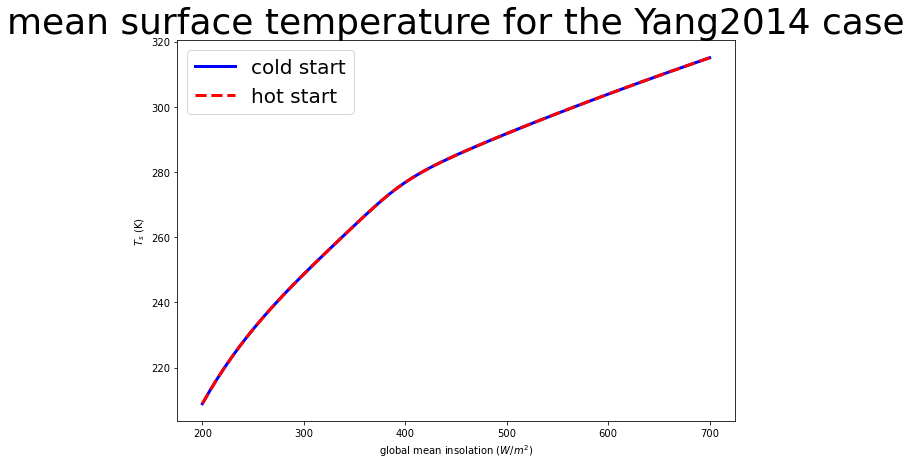

In [4]:
# Check the bifurcation for the Y2014 case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, Ts_cold_Yang2014, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, Ts_hot_Yang2014, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'mean surface temperature for the Yang2014 case')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

In [5]:
### Y14R case: with dayside cloud, no nightside cloud, runaway, no SW absorption, water vapor as a tracer

## Sweep over the parameter space with a cold start

# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
#     print(idx, s)
    
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                       LW = 'Yang2014', SW = 'constant', TOA = 'ideal runaway', 
                       daycloud = 'default', nightcloud = 'default',
                       T_run = 280, T_end = 700,
                       p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'constant', TOA = 'ideal runaway', 
                           daycloud = 'default', nightcloud = 'default',
                           T_run = 280, T_end = 700,
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)

# Save the array for the insolation
so_cold = so

## extract output values from cold_list
T1_cold = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold = np.array([d['T4'] for d in cold_list])

q2_cold = np.array([d['q2'] for d in cold_list])
q3_cold = np.array([d['q3'] for d in cold_list])

Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold = np.array([d['Fc'] for d in cold_list])

fc_cold = np.array([d['fc'] for d in cold_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])

ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

a2_cold = np.array([d['a_2'] for d in cold_list])

## Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
#     print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                       LW = 'Yang2014', SW = 'constant', TOA = 'ideal runaway', 
                       daycloud = 'default', nightcloud = 'default',
                       T_run = 280, T_end = 700,
                       p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0,  
                           LW = 'Yang2014', SW = 'constant', TOA = 'ideal runaway', 
                           daycloud = 'default', nightcloud = 'default',
                           T_run = 280, T_end = 700, 
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)

## Save the array for the insolation
so_hot = so

## extract output values from hot_list
T1_hot = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot = np.array([d['T4'] for d in hot_list])

q2_hot = np.array([d['q2'] for d in hot_list])
q3_hot = np.array([d['q3'] for d in hot_list])

Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot = np.array([d['Fc'] for d in hot_list])

fc_hot = np.array([d['fc'] for d in hot_list])

ap_hot = np.array([d['alpha_p'] for d in hot_list])

ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

e2_hot = np.array([d['epsl_2'] for d in hot_list])

a2_hot = np.array([d['a_2'] for d in hot_list])

Ts_cold_Y14R = (T1_cold+T4_cold)/2
Ts_hot_Y14R = (T1_hot+T4_hot)/2
q_cold_Y14R = (q2_cold+q3_cold)/2
q_hot_Y14R = (q2_hot+q3_hot)/2

ap_cold_Y14R = ap_cold
ap_hot_Y14R = ap_hot
Fc_cold_Y14R = Fc_cold
Fc_hot_Y14R = Fc_hot
fc_cold_Y14R = fc_cold
fc_hot_Y14R = fc_hot
OLR_cold_Y14R = (OLR_cold_day + OLR_cold_night) / 2
OLR_hot_Y14R = (OLR_hot_day + OLR_hot_night) / 2
abs_cold_Y14R = (1 - ap_cold) * (a2_cold)
abs_hot_Y14R = (1 - ap_hot) * (a2_hot)

RC_cold_Y14R = Fc_cold - 0.2 * Fa_cold
RC_hot_Y14R = Fc_hot - 0.2 * Fa_hot

No solution for the cold branch, switch to hot branch instead 

No solution for the hot branch, switch to cold branch instead 



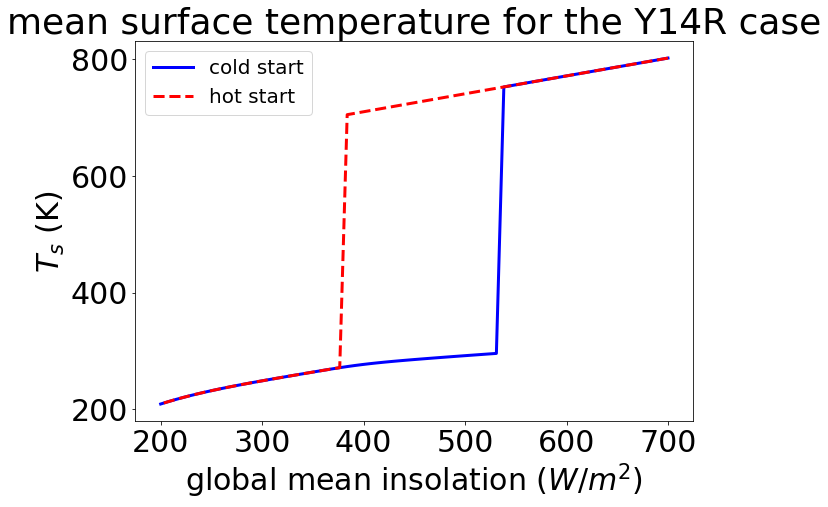

In [6]:
# Check the bifurcation for the Y14R case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, Ts_cold_Y14R, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, Ts_hot_Y14R, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'mean surface temperature for the Y14R case')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

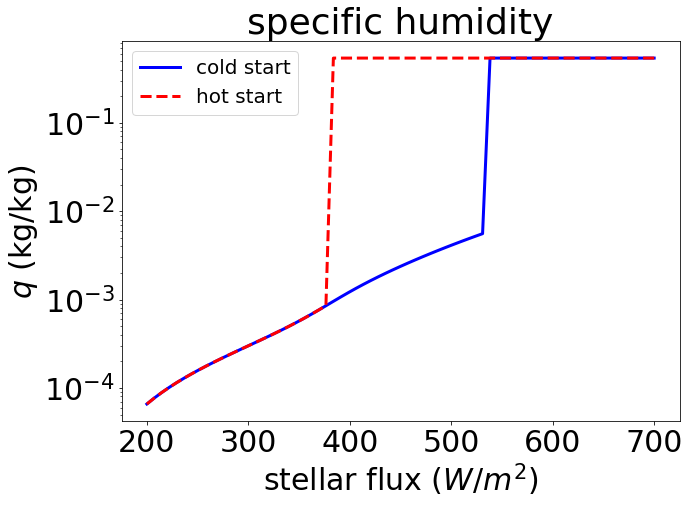

In [172]:
# Check the bifurcation for the Y14R case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, q_cold_Y14R, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, q_hot_Y14R, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$q$ (kg/kg)')
    ax.set_xlabel(r'stellar flux ($W/m^2$)')
    ax.set_title(r'specific humidity')
    ax.legend(loc = 'upper left',fontsize=20)
    ax.set_yscale('log')
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

No solution for the cold branch, switch to hot branch instead 

No solution for the hot branch, switch to cold branch instead 



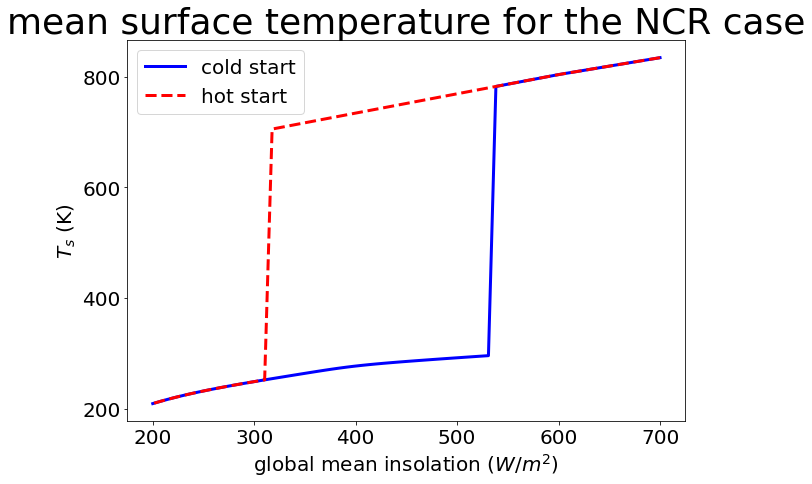

In [10]:
### NCR case: dayside cloud, nightside cloud, runaway greenhouse, no SW absorption, water vapor atmosphere

## Sweep over the parameter space with a cold start

# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
#     print(idx, s)
    
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                       LW = 'feedback', SW = 'constant', TOA = 'ideal runaway', 
                       daycloud = 'default', nightcloud = 'transition',k3 = 0.08,
                       T_run = 280, T_end = 700, F_NC = 200,
                       p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'feedback', SW = 'constant', TOA = 'ideal runaway', 
                           daycloud = 'default', nightcloud = 'transition',k3 = 0.08,
                           T_run = 280, T_end = 700, F_NC = 200,
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)

# Save the array for the insolation
so_cold = so

## extract output values from cold_list
T1_cold = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold = np.array([d['T4'] for d in cold_list])

Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold = np.array([d['Fc'] for d in cold_list])

fc_cold = np.array([d['fc'] for d in cold_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])

ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

## Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 2800, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
#     print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                       LW = 'feedback', SW = 'constant', TOA = 'ideal runaway', 
                       daycloud = 'default', nightcloud = 'transition',k3 = 0.08,
                       T_run = 280, T_end = 700,F_NC = 200,
                       p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'feedback', SW = 'constant', TOA = 'ideal runaway', 
                           daycloud = 'default', nightcloud = 'transition',k3 = 0.08,
                           T_run = 280, T_end = 700, F_NC = 200,
                           p_guess=initial_guess, output = 'dict')        
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)

## Save the array for the insolation
so_hot = so

## extract output values from hot_list
T1_hot = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot = np.array([d['T4'] for d in hot_list])

Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot = np.array([d['Fc'] for d in hot_list])

fc_hot = np.array([d['fc'] for d in hot_list])

ap_hot = np.array([d['alpha_p'] for d in hot_list])

ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

e2_hot = np.array([d['epsl_2'] for d in hot_list])

a2_hot = np.array([d['a_2'] for d in hot_list])

Ts_cold_NCR = (T1_cold+T4_cold)/2
Ts_hot_NCR = (T1_hot+T4_hot)/2

# Check the bifurcation for the NCR case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, Ts_cold_NCR, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, Ts_hot_NCR, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'mean surface temperature for the NCR case')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

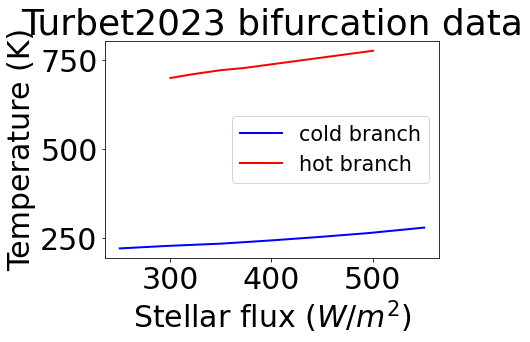

In [8]:
# read Turbet2023 bifurcation data
# read data
coldts = pd.read_csv('./screenshots/Turbet2023_data/T-S-cold.csv',header=None)
# assign headers
coldts.columns = ["S", "T"]
# make data in right order (necessary for interpolation)
coldts = coldts.sort_values(by=['S'], ascending=True)
# interpolate data to a consistent pressure coordinate
S0 = coldts['S']; T0 = coldts['T'];
S_TB2023_cold = 340.25 * S0
T_TB2023_cold = T0
# P = np.logspace(2, 6, 100)
# cs = CubicSpline(P0, T0)
# T_TB2023 = cs(P)

# read data
hotts = pd.read_csv('./screenshots/Turbet2023_data/T-S-hot.csv',header=None)
# assign headers
hotts.columns = ["S", "T"]
# make data in right order (necessary for interpolation)
hotts = hotts.sort_values(by=['S'], ascending=True)
# interpolate data to a consistent pressure coordinate
S0 = hotts['S']; T0 = hotts['T'];
S_TB2023_hot = 340.25 * S0
T_TB2023_hot = T0
# P = np.logspace(2, 6, 100)
# cs = CubicSpline(P0, T0)
# T_TB2023 = cs(P)

# plot
fig, ax = plt.subplots()

# ax.plot(T0, P0, linewidth=2.0,label = 'original')
ax.plot(S_TB2023_cold, T_TB2023_cold, 'b-',linewidth = 2.0, label = 'cold branch')
ax.plot(S_TB2023_hot, T_TB2023_hot, 'r-',linewidth = 2.0, label = 'hot branch')
# ax.plot(280,900,'r+',label='CC')

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.title("Turbet2023 bifurcation data")
plt.ylabel("Temperature (K)")
plt.xlabel(r"Stellar flux ($W/m^2$)")
plt.rcParams.update({'font.size': 30})
plt.rcParams["figure.figsize"] = (7,5)
ax.legend(loc='best', fontsize='x-small')
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.show()

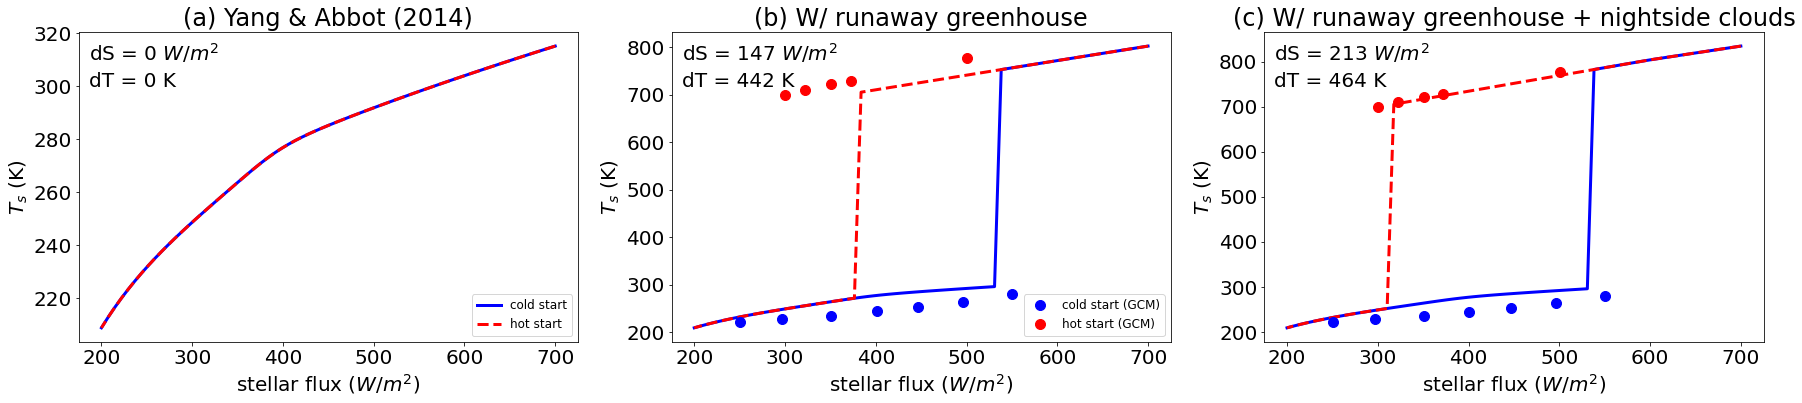

In [14]:
import matplotlib.gridspec as gridspec

# Check the bifurcation for the NCR case
def bifurcation(so, Ts_cold0, Ts_hot0): 
    
    Ts_cold = Ts_cold0
    Ts_hot = np.flip(Ts_hot0)
    
    # Find where the difference is greater than 10
    condition = Ts_hot - Ts_cold > 10

    # Extract the indices where the condition is True
    indices = np.where(condition)[0]
    
    if indices.size == 0:
        return 0, 0
    else:
        dT = sum(Ts_hot[indices]-Ts_cold[indices]) / len(Ts_hot[indices])
        dS = np.max(so[indices]) - np.min(so[indices])        
    return dT,dS

# Create a figure
fig = plt.figure(figsize=(25, 6))
plt.rc('font', size = 20)

# Define the grid layout
gs = gridspec.GridSpec(1, 3)  # 1 rows, 2 columns to allow centering

# Create subplots
# First row, centered panels
ax1 = fig.add_subplot(gs[0, 0])  # Spans from the second to the third column
ax2 = fig.add_subplot(gs[0, 1])  # Spans from the fourth to the fifth column
ax3 = fig.add_subplot(gs[0, 2])  # Spans from the fourth to the fifth column

ax1.plot(so_cold/4, Ts_cold_Yang2014, '-', color = 'blue',linewidth=3, label = r'cold start')
ax1.plot(so_hot/4, Ts_hot_Yang2014, '--', color = 'red', linewidth=3, label = r'hot start')
ax1.set_ylabel(r'$T_s$ (K)')
ax1.set_xlabel(r'stellar flux ($W/m^2$)')
ax1.set_title(r'(a) Yang & Abbot (2014)')
#     ax2.legend(loc = 'upper left',fontsize=20,)
ax1.legend(loc = 'lower right',fontsize=12)
dT, ds =  bifurcation(so_cold/4, Ts_cold_Yang2014, Ts_hot_Yang2014)
ax1.text(0.02, 0.97,f'dS = {int(ds)} $W/m^2$', transform=ax1.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax1.text(0.02, 0.87,  f'dT = {int(dT)} K', transform=ax1.transAxes, ha='left', va='top', fontsize=20)  # Text for B
  
ax2.plot(so_cold/4, Ts_cold_Y14R, '-', color = 'blue',linewidth=3)
ax2.plot(so_hot/4, Ts_hot_Y14R, '--', color = 'red', linewidth=3)
ax2.plot(S_TB2023_cold, T_TB2023_cold, 'bo',markersize=10, label = 'cold start (GCM)')
ax2.plot(S_TB2023_hot, T_TB2023_hot, 'ro',markersize = 10, label = 'hot start (GCM)')
ax2.set_ylabel(r'$T_s$ (K)')
ax2.set_xlabel(r'stellar flux ($W/m^2$)')
ax2.set_title(r'(b) W/ runaway greenhouse')
ax2.legend(loc = 'lower right',fontsize=12)
#     ax3.legend(loc = 'upper left',fontsize=20,)
dT, ds =  bifurcation(so_cold/4, Ts_cold_Y14R, Ts_hot_Y14R)
ax2.text(0.02, 0.97, f'dS = {int(ds)} $W/m^2$', transform=ax2.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax2.text(0.02, 0.87,  f'dT = {int(dT)} K', transform=ax2.transAxes, ha='left', va='top', fontsize=20)  # Text for B

ax3.plot(so_cold/4, Ts_cold_NCR, '-', color = 'blue',linewidth=3)
ax3.plot(so_hot/4, Ts_hot_NCR, '--', color = 'red', linewidth=3)
ax3.plot(S_TB2023_cold, T_TB2023_cold, 'bo',markersize=10, label = 'cold branch')
ax3.plot(S_TB2023_hot, T_TB2023_hot, 'ro',markersize=10, label = 'hot branch')
ax3.set_ylabel(r'$T_s$ (K)')
ax3.set_xlabel(r'stellar flux ($W/m^2$)')
ax3.set_title(r'(c) W/ runaway greenhouse + nightside clouds')
#     ax3.legend(loc = 'upper left',fontsize=20,)
dT, ds =  bifurcation(so_cold/4, Ts_cold_NCR, Ts_hot_NCR)
ax3.text(0.02, 0.97, f'dS = {int(ds)} $W/m^2$', transform=ax3.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax3.text(0.02, 0.87, f'dT = {int(dT)} K', transform=ax3.transAxes, ha='left', va='top', fontsize=20)  # Text for B

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

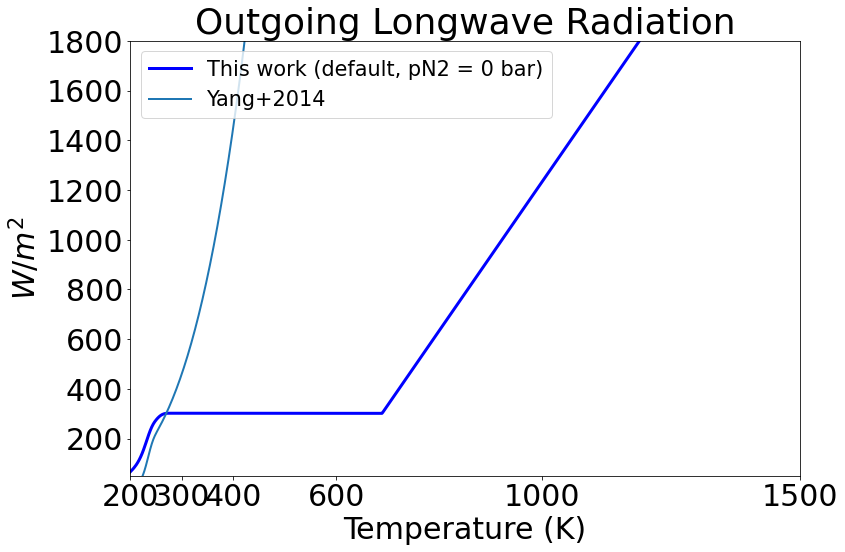

In [32]:
# A even more realistic scheme for LW absorption
RH = 1           # Dayside atmosphere relative humidity
es0 = 611.2         # reference pressure for CC relation
M = 0.018           # molar mass of water vapor
mm_dry = 0.028      # molar mass of dry air
mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
L = 2.501e6                 # latent heat of vaporization in J/kg
To = 273.15                 # reference temperature for CC relation
R_star = 8.3145         # universal gas constant
Pc = 6e4
g = 13.7
sigma = 5.67e-8

T_test = np.linspace(200, 1500, 900)
es = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T_test))  # saturation vapor pressure
qs = mass_ratio*es/(Pc+mass_ratio*es) # saturated mixing ratio
q = RH * qs                 # vapor pressure 
# q = w / (1+w)               # specific humidity

# kappa1 = 5e-3
# k1 = kappa1*(Pc+es)/g
k1 = 5000
e1_test = 1 - np.exp(-k1*q)

kappa1 = k1 * g / Pc
kappa2 = kappa1
k2 = kappa2*(Pc+es)/g
e2_test = 1 - np.exp(-k2*q)

OLR1 = e2_test*sigma*T_test**4

trans_data = pd.read_csv('./screenshots/Chaverot2021_data/Ts-Trans.csv',header=None)
# assign headers
trans_data.columns = ["Ts", "Trans"]
# make data in right order (necessary for interpolation)
trans_data = trans_data.sort_values(by=['Ts'], ascending=True)
# print(temperate_LW)
# interpolate data to a consistent temperature coordinate
Trans0 = trans_data['Trans']; Ts0 = trans_data['Ts'];
# T_test = np.linspace(220, 380, 100)
Trans_K2018 = np.interp(T_test, Ts0, Trans0)
# cs = CubicSpline(Ts0, Trans0)
# Trans_K2018 = cs(T_test)
# Trans_K2018[Trans_K2018 < 0.01] = 0
# print(Trans_K2018)

T1 = 270
# OLR2 = Trans_K2018 * e2_test*sigma*T_test**4 + (1-Trans_K2018) * sigma * T1 ** 4

# OLR3 = OLR2 - 1e-9
# OLR3[T_test>700] = 5.67e-3*(T_test[T_test>700]-700)**2 + sigma*T1**4

# Trans_0p1 = np.interp(T_test, Ts0-15, Trans0)
# OLR4 = Trans_0p1 * e2_test*sigma*T_test**4 + (1-Trans_0p1) * sigma * T1 ** 4
# OLR4[T_test>850] = 5.67e-3*(T_test[T_test>850]-850)**2 + sigma*T1**4

Trans_0 = np.interp(T_test, Ts0-30, Trans0)
OLR5 = Trans_0 * e2_test*sigma*T_test**4 + (1-Trans_0) * sigma * T1 ** 4
T_ref = 270
index_T_ref = (np.abs(T_test - T_ref)).argmin()
OLR_ref = OLR5[index_T_ref]
# Create OLR6 based on conditions
slope = 3
T_end =689
OLR5[T_test>T_end] = OLR_ref + slope * (T_test[T_test>T_end] - T_end)

# 5.67e-3*(T_test[T_test>700]-700)**2 + sigma*T1**4

# OLR6 = np.zeros_like(T_test, dtype=float)
# T_ref = 270
# # Find the index of the value in T_test closest to T_ref
# index_T_ref = (np.abs(T_test - T_ref)).argmin()
# OLR_ref = OLR5[index_T_ref]
# # Create OLR6 based on conditions
# slope = 3
# for i, T in enumerate(T_test):
#     if T < T_ref:
#         OLR6[i] = OLR_ref - slope * (T_ref - T)
#     elif T == T_ref:
#         OLR6[i] = OLR_ref
#     elif T > 700:
#         OLR6[i] = OLR_ref + slope * (T - 700)
#     else:
#         OLR6[i] = OLR_ref


# Official plot for the radiation scheme
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(T_test,np.gradient(OLR6),'--k')

# ax.plot(T0, P0, linewidth=2.0,label = 'original')
ax.plot(T_test, OLR5, '-b',linewidth=3.0,label = 'This work (default, pN2 = 0 bar)')
# ax.plot(T_test, OLR6, '--b',linewidth=3.0,label = 'Linearized OLR')
# ax.plot(T_test, OLR7, '--r',linewidth=3.0,label = 'Test2')
ax.plot(T_test, OLR1, linewidth=2.0,label = 'Yang+2014')
# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))
ax.set_title("Outgoing Longwave Radiation")
ax.set_xlabel("Temperature (K)")
ax.set_ylabel(r"$W/m^2$")
# plt.gca().invert_yaxis()
ax.legend(loc='upper left', fontsize='x-small')
ax.set_ylim(50, 1800)
ax.set_xlim(200, 1500)
# ax.set_xscale('log')
ax.set_xticks([200,300,400,600,1000,1500]) 
ax.set_xticklabels([200,300,400,600, 1000, 1500]) 
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30,8)

plt.show()


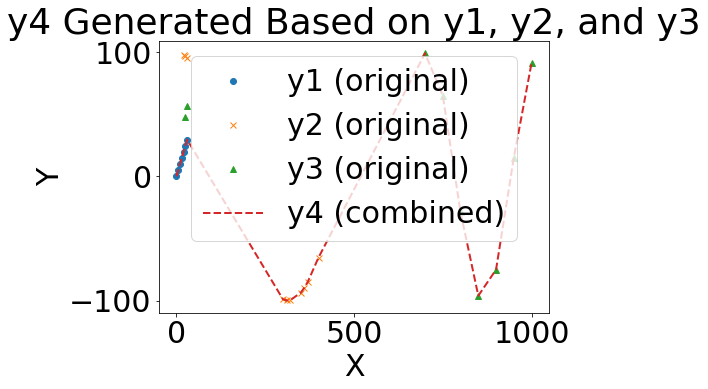

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def generate_combined_data(x1, y1, x2, y2, x3, y3, range1=300, range2=700):
    """
    Generate combined x_full and y4 based on given data and specified ranges.
    Handles overlapping x ranges and applies boundaries.
    """
    # Sort data based on x values
    sorted_indices_1 = np.argsort(x1)
    x1, y1 = x1[sorted_indices_1], y1[sorted_indices_1]
    
    sorted_indices_2 = np.argsort(x2)
    x2, y2 = x2[sorted_indices_2], y2[sorted_indices_2]
    
    sorted_indices_3 = np.argsort(x3)
    x3, y3 = x3[sorted_indices_3], y3[sorted_indices_3]
    
    # Combine all x and y data
    x_sorted = np.concatenate((x1, x2, x3))
    y_sorted = np.concatenate((y1, y2, y3))

    # Initialize y4 with NaNs to indicate missing data
    y4 = np.full_like(x_sorted, np.nan, dtype=np.float64)

    # Assign values to y4 based on conditions with boundaries
    mask1 = x_sorted < range1
    mask2 = (x_sorted >= range1) & (x_sorted < range2)
    mask3 = x_sorted >= range2

    # Interpolate values within each range, avoiding extrapolation
    if np.any(mask1):
        y4[mask1] = np.interp(x_sorted[mask1], x1, y1, left=np.nan, right=np.nan)
    if np.any(mask2):
        y4[mask2] = np.interp(x_sorted[mask2], x2, y2, left=np.nan, right=np.nan)
    if np.any(mask3):
        y4[mask3] = np.interp(x_sorted[mask3], x3, y3, left=np.nan, right=np.nan)

#     return x_sorted, y4

    # Double-check the sequence and re-sort if necessary
    sorted_indices_final = np.argsort(x_sorted)
    x_sorted_final = x_sorted[sorted_indices_final]
    y4_final = y4[sorted_indices_final]

    return x_sorted_final, y4_final

# Example data
x1 = np.array([10, 5, 20, 0, 15, 25, 30])  # Unsorted x1 range
y1 = np.sin(x1 / 100) * 100                # Example y1 values

x2 = np.array([350, 300, 400, 370, 360, 310, 320, 20, 25, 30])  # Overlapping x2 range
y2 = np.cos(x2 / 100) * 100                                  # Example y2 values

x3 = np.array([750, 900, 850, 800, 700, 950, 1000, 25, 30]) # Overlapping x3 range
y3 = np.sin(x3 / 50) * 100                                  # Example y3 values

# Generate combined data
x_full, y4 = generate_combined_data(x1, y1, x2, y2, x3, y3, range1=300, range2=700)

# Plot the result to visualize y4
plt.plot(x1, y1, 'o', label='y1 (original)')
plt.plot(x2, y2, 'x', label='y2 (original)')
plt.plot(x3, y3, '^', label='y3 (original)')
plt.plot(x_full, y4, label='y4 (combined)', linestyle='--', linewidth=2)

# Set axis labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('y4 Generated Based on y1, y2, and y3')
plt.legend()

# Show the plot
plt.show()


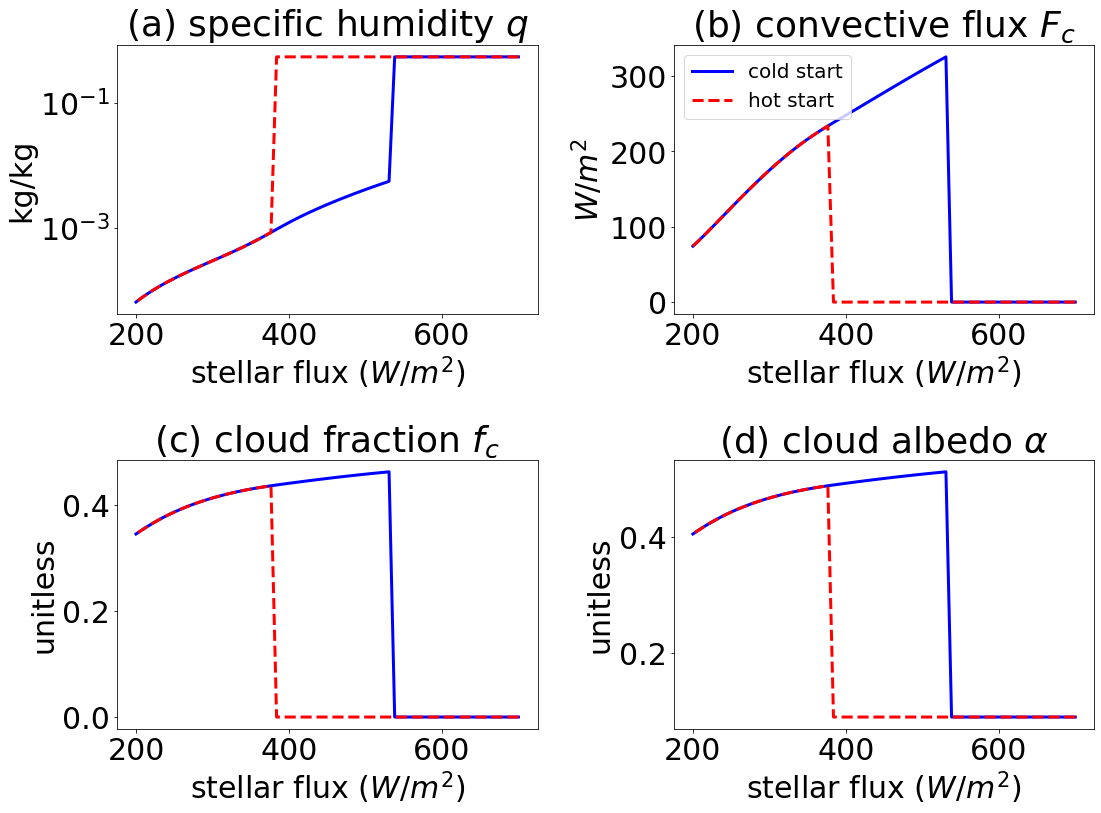

In [76]:
plt.subplots(2, 2, figsize=(16,12)) 
plt.rc('font', size = 30) 
    
plt.subplot(2,2,2)
plt.plot(so_cold/4, (Fc_cold_Y14R), '-', color = 'blue',linewidth=3, label = r'cold start')
plt.plot(so_hot/4, (Fc_hot_Y14R), '--', color = 'red', linewidth=3, label = r'hot start')
plt.ylabel(r'$W/m^2$')
plt.xlabel(r'stellar flux ($W/m^2$)')
plt.title(r'(b) convective flux $F_c$')
plt.legend(loc = 'upper left',fontsize=20)

plt.subplot(2,2,3)
plt.plot(so_cold/4, (fc_cold_Y14R), '-', color = 'blue',linewidth=3)
plt.plot(so_hot/4, (fc_hot_Y14R), '--', color = 'red', linewidth=3)
plt.ylabel(r'unitless')
plt.xlabel(r'stellar flux ($W/m^2$)')
plt.title(r'(c) cloud fraction $f_c$')

plt.subplot(2,2,4)
plt.plot(so_cold/4, (ap_cold_Y14R), '-', color = 'blue',linewidth=3)
plt.plot(so_hot/4, (ap_hot_Y14R), '--', color = 'red', linewidth=3)
plt.ylabel(r'unitless')
plt.xlabel(r'stellar flux ($W/m^2$)')
plt.title(r'(d) cloud albedo $\alpha$')

plt.subplot(2,2,1)
# Dayside temperature structure
plt.plot(so_cold/4, q_cold_Y14R, '-', color = 'blue',linewidth=3, label = r'cold start')
plt.plot(so_hot/4, q_hot_Y14R, '--', color = 'red', linewidth=3, label = r'hot start')
plt.ylabel(r'kg/kg')
plt.xlabel(r'stellar flux ($W/m^2$)')
plt.title(r'(a) specific humidity $q$')
# plt.legend(loc = 'upper left',fontsize=20)
plt.yscale('log')


plt.tight_layout()
plt.show()
        

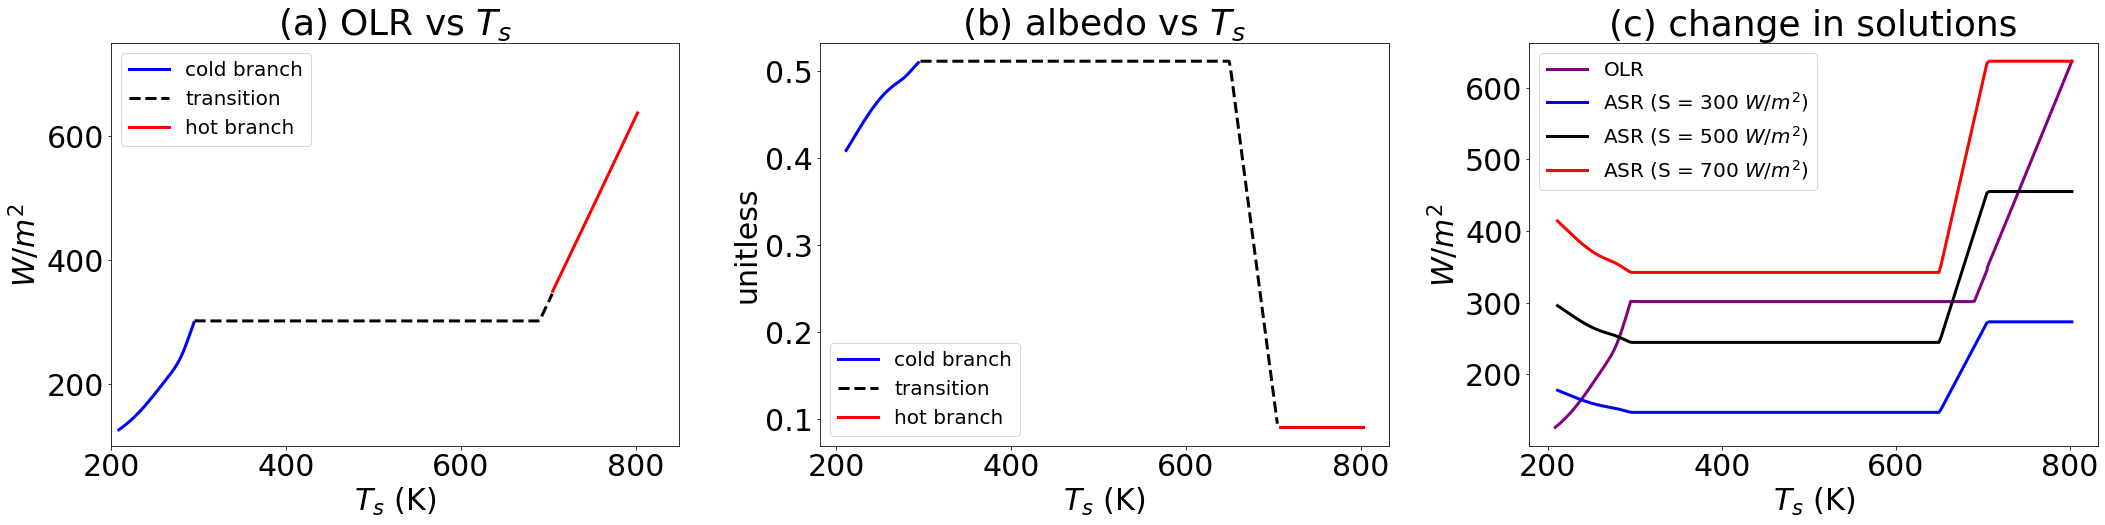

In [25]:
plt.subplots(1, 3, figsize=(30,8)) 
plt.rc('font', size = 30) 

plt.subplot(1,3,1)
T_net_OLR, OLR_net = generate_combined_data(Ts_cold_Y14R, OLR_cold_Y14R,
                            T_test, OLR5, Ts_hot_Y14R, OLR_hot_Y14R, 
                            range1 = 295,range2=705)
# Plot x1 vs y1 when x < range1
mask1 = T_net_OLR < 295
plt.plot(T_net_OLR[mask1], OLR_net[mask1], '-b', label='cold branch',linewidth=3)
# Plot x2 vs y2 when range1 <= x < range2
mask2 = (T_net_OLR >= 295) & (T_net_OLR < 705)
plt.plot(T_net_OLR[mask2], OLR_net[mask2], '--k', label='transition',linewidth=3)
# Plot x3 vs y3 when x >= range2
mask3 = T_net_OLR >= 705
plt.plot(T_net_OLR[mask3], OLR_net[mask3], '-r', label='hot branch',linewidth=3)
plt.ylabel(r'$W/m^2$')
plt.xlabel(r'$T_s$ (K)')
plt.xlim(200, 850)
plt.ylim(100, 750)
plt.legend(loc = 'upper left',fontsize=20)
#     ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,0].set_xlabel(r'global mean insolation ($W/m^2$)')
plt.title(r'(a) OLR vs $T_s$')

plt.subplot(1,3,2)
# Generate x2 to fill the gap between max(x1) and min(x3)
T2_start = 650
T2_end = np.min(Ts_hot_Y14R)
T2 = np.linspace(T2_start, T2_end, 100)  # Example: 100 points in the gap
ap2 = np.full_like(T2, np.max(ap_cold_Y14R))        # y2 equals to max(y1)
T_net_ap, ap_net = generate_combined_data(Ts_cold_Y14R, ap_cold_Y14R,
                            T2, ap2, Ts_hot_Y14R, ap_hot_Y14R, 
                            range1 = 295,range2=705)
# Create a regular grid within the range of x_sorted_final
T_grid_ap = np.linspace(T_net_ap[0], T_net_ap[-1], len(T_net_ap))
# Interpolate y4_final onto the regular grid
ap_grid = np.interp(T_grid_ap, T_net_ap, ap_net)
# plt.plot(T_grid_ap, ap_grid, 'o', color = 'purple', markersize=5,linewidth=5.0)
# Plot x1 vs y1 when x < range1
mask1 = T_grid_ap < 295
plt.plot(T_grid_ap[mask1], ap_grid[mask1], '-b', label='cold branch',linewidth=3)
# Plot x2 vs y2 when range1 <= x < range2
mask2 = (T_grid_ap >= 295) & (T_grid_ap < 705)
plt.plot(T_grid_ap[mask2], ap_grid[mask2], '--k', label='transition',linewidth=3)
# Plot x3 vs y3 when x >= range2
mask3 = T_grid_ap >= 705
plt.plot(T_grid_ap[mask3], ap_grid[mask3], '-r', label='hot branch',linewidth=3)
plt.ylabel(r'unitless')
plt.xlabel(r'$T_s$ (K)')
plt.legend(loc = 'lower left',fontsize=20)
#     ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,0].set_xlabel(r'global mean insolation ($W/m^2$)')
plt.title(r'(b) albedo vs $T_s$')

plt.subplot(1,3,3)
plt.plot(T_net_OLR, OLR_net, '-', color = 'purple', label='OLR', linewidth=3)
plt.plot(T_grid_ap, 300*(1-ap_grid), '-', color = 'blue',
         label=r'ASR (S = 300 $W/m^2$)',linewidth=3.0)
plt.plot(T_grid_ap, 500*(1-ap_grid), '-', color = 'black',
         label=r'ASR (S = 500 $W/m^2$)', linewidth=3.0)
plt.plot(T_grid_ap, 700*(1-ap_grid), '-', color = 'red',
         label=r'ASR (S = 700 $W/m^2$)',linewidth=3.0)
plt.title(r'(c) change in solutions')
plt.ylabel(r'$W/m^2$')
plt.xlabel(r'$T_s$ (K)')
plt.legend(loc = 'upper left',fontsize=20)

plt.tight_layout()
plt.show()
        

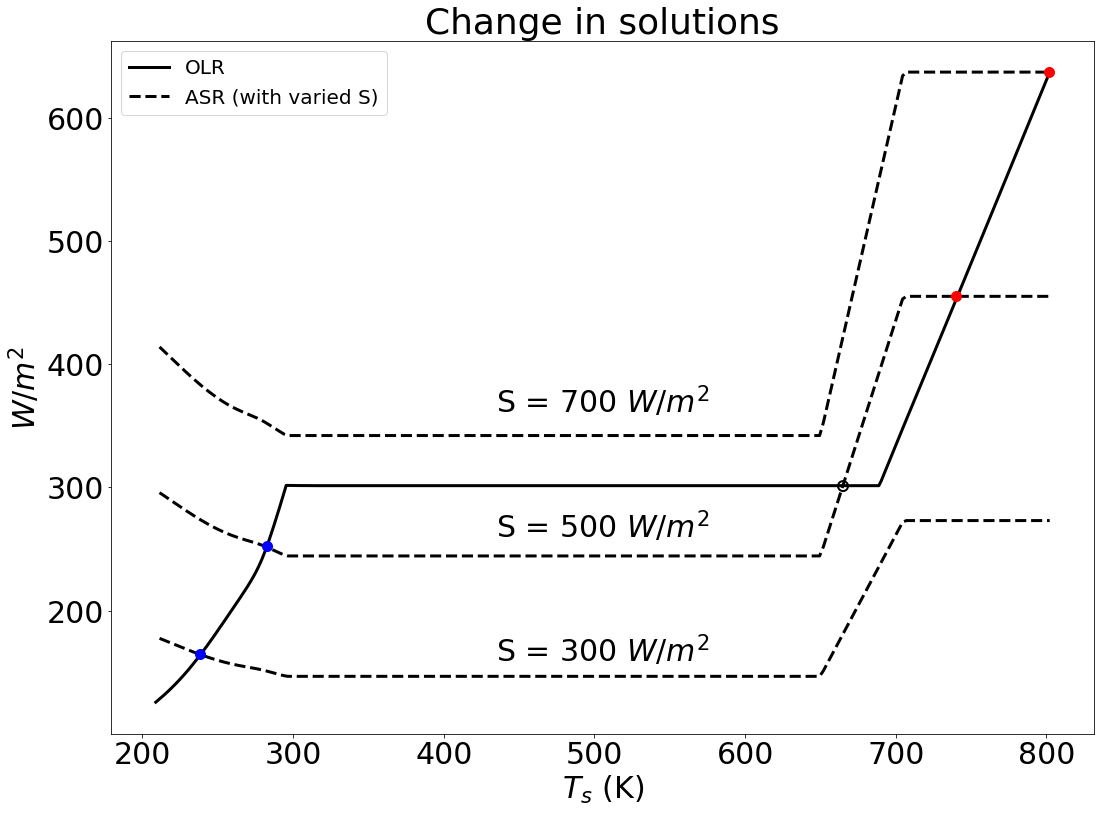

In [75]:
T_net_OLR, OLR_net = generate_combined_data(Ts_cold_Y14R, OLR_cold_Y14R,
                            T_test, OLR5, Ts_hot_Y14R, OLR_hot_Y14R, 
                            range1 = 295,range2=705)
T2_start = 650
T2_end = np.min(Ts_hot_Y14R)
T2 = np.linspace(T2_start, T2_end, 100)  # Example: 100 points in the gap
ap2 = np.full_like(T2, np.max(ap_cold_Y14R))        # y2 equals to max(y1)
T_net_ap, ap_net = generate_combined_data(Ts_cold_Y14R, ap_cold_Y14R,
                            T2, ap2, Ts_hot_Y14R, ap_hot_Y14R, 
                            range1 = 295,range2=705)

plt.subplots(1, 1, figsize=(16,12)) 
plt.rc('font', size = 30) 
plt.plot(T_net_OLR, OLR_net, '-', color = 'black', label='OLR', linewidth=3)
plt.plot(T_grid_ap, 300*(1-ap_grid), '--', color = 'black',
         label=r'ASR (with varied S)',linewidth=3.0)
plt.text(0.5, 0.12, r'S = 300 $W/m^2$', ha='center', va='center', fontsize=30, transform=plt.gca().transAxes)
plt.plot(T_grid_ap, 500*(1-ap_grid), '--', color = 'black',
          linewidth=3.0)
plt.text(0.5, 0.3, r'S = 500 $W/m^2$', ha='center', va='center', fontsize=30, transform=plt.gca().transAxes)
plt.plot(T_grid_ap, 700*(1-ap_grid), '--', color = 'black',
         linewidth=3.0)
plt.text(0.5, 0.48, r'S = 700 $W/m^2$', ha='center', va='center', fontsize=30, transform=plt.gca().transAxes)
plt.scatter(238, 165, color='blue', s=100, zorder=5)  # Blue closed circle
plt.scatter(283, 252, color='blue', s=100, zorder=5)  # Blue closed circle
plt.scatter(665, 301, edgecolor='black', facecolor='none', s=100, linewidth=2, zorder=5)  # Black open circle
plt.scatter(740, 455, color='red', s=100, zorder=5)  # Red closed circle
plt.scatter(802, 637, color='red', s=100, zorder=5)  # Red closed circle
# plt.title(r'Change in solutions')
plt.ylabel(r'$W/m^2$')
plt.xlabel(r'$T_s$ (K)')
plt.legend(loc = 'upper left',fontsize=20)
plt.tight_layout()
plt.show()


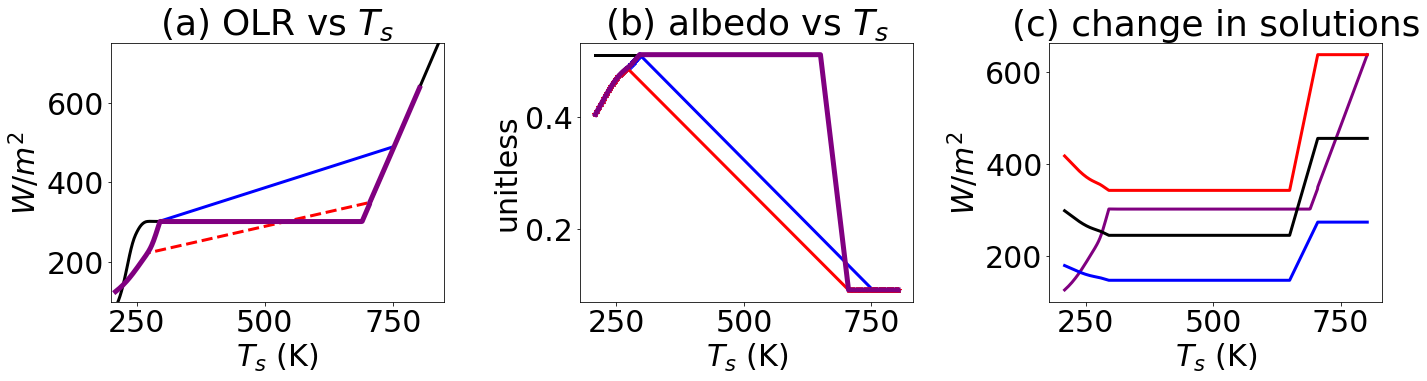

In [177]:
plt.subplots(1, 3, figsize=(20,6)) 
plt.rc('font', size = 30) 

plt.subplot(1,3,1)
plt.plot(Ts_cold_Y14R, OLR_cold_Y14R, '-', color = 'blue',linewidth=3)
plt.plot(Ts_hot_Y14R, OLR_hot_Y14R, '--', color = 'red', linewidth=3)
plt.plot(T_test, OLR5, '-', color = 'black',linewidth=3.0, label = 'This work (default, pN2 = 0 bar)')
T_net_OLR, OLR_net = generate_combined_data(Ts_cold_Y14R, OLR_cold_Y14R,
                            T_test, OLR5, Ts_hot_Y14R, OLR_hot_Y14R, 
                            range1 = 295,range2=705)
plt.plot(T_net_OLR, OLR_net, '-', color = 'purple', markersize=5, linewidth=5)
plt.ylabel(r'$W/m^2$')
plt.xlabel(r'$T_s$ (K)')
plt.xlim(200, 850)
plt.ylim(100, 750)
#     ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,0].set_xlabel(r'global mean insolation ($W/m^2$)')
plt.title(r'(a) OLR vs $T_s$')

plt.subplot(1,3,2)
plt.plot(Ts_cold_Y14R, ap_cold_Y14R, '-*', color = 'blue',linewidth=3)
plt.plot(Ts_hot_Y14R, ap_hot_Y14R, '-*', color = 'red', linewidth=3)
# Generate x2 to fill the gap between max(x1) and min(x3)
T2_start = 650
T2_end = np.min(Ts_hot_Y14R)
T2 = np.linspace(T2_start, T2_end, 100)  # Example: 100 points in the gap
ap2 = np.full_like(T2, np.max(ap_cold_Y14R))        # y2 equals to max(y1)
T_net_ap, ap_net = generate_combined_data(Ts_cold_Y14R, ap_cold_Y14R,
                            T2, ap2, Ts_hot_Y14R, ap_hot_Y14R, 
                            range1 = 295,range2=705)
plt.plot(T2, ap2, '-', color = 'black',linewidth=3.0)
plt.plot(T_net_ap, ap_net, '-', color = 'purple', markersize=5,linewidth=5.0)
plt.ylabel(r'unitless')
plt.xlabel(r'$T_s$ (K)')
#     ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,0].set_xlabel(r'global mean insolation ($W/m^2$)')
plt.title(r'(b) albedo vs $T_s$')

plt.subplot(1,3,3)
plt.plot(T_net_OLR, OLR_net, '-', color = 'purple', markersize=5, linewidth=3)
plt.plot(T_net_ap, 300*(1-ap_net), '-', color = 'blue', markersize=5,linewidth=3.0)
plt.plot(T_net_ap, 500*(1-ap_net), '-', color = 'black', markersize=5,linewidth=3.0)
plt.plot(T_net_ap, 700*(1-ap_net), '-', color = 'red', markersize=5,linewidth=3.0)
plt.title(r'(c) change in solutions')
plt.ylabel(r'$W/m^2$')
plt.xlabel(r'$T_s$ (K)')

plt.tight_layout()
plt.show()
        

In [15]:
### Y14A case: with dayside cloud, no nightside cloud, no runaway, SW absorption, water vapor as a tracer

## Sweep over the parameter space with a cold start

# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 6000, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
#     print(idx, s)
    
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014', 
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014',  
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)

# Save the array for the insolation
so_cold = so

## extract output values from cold_list
T1_cold = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold = np.array([d['T4'] for d in cold_list])

Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold = np.array([d['Fc'] for d in cold_list])

fc_cold = np.array([d['fc'] for d in cold_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])

ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

a2_cold = np.array([d['a_2'] for d in cold_list])

## Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 6000, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
#     print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014',  
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                           LW = 'Yang2014', SW = 'feedback', TOA = 'Yang2014',  
                           daycloud = 'default', nightcloud = 'default',
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)

## Save the array for the insolation
so_hot = so

## extract output values from hot_list
T1_hot = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot = np.array([d['T4'] for d in hot_list])

Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot = np.array([d['Fc'] for d in hot_list])

fc_hot = np.array([d['fc'] for d in hot_list])

ap_hot = np.array([d['alpha_p'] for d in hot_list])

ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

e2_hot = np.array([d['epsl_2'] for d in hot_list])

a2_hot = np.array([d['a_2'] for d in hot_list])

Ts_cold_Y14A = (T1_cold+T4_cold)/2
Ts_hot_Y14A = (T1_hot+T4_hot)/2

ap_cold_Y14A = ap_cold
ap_hot_Y14A = ap_hot
Fc_cold_Y14A = Fc_cold
Fc_hot_Y14A = Fc_hot
fc_cold_Y14A = fc_cold
fc_hot_Y14A = fc_hot
OLR_cold_Y14A = (OLR_cold_day + OLR_cold_night) / 2
OLR_hot_Y14A = (OLR_hot_day + OLR_hot_night) / 2
abs_cold_Y14A = (1 - ap_cold) * (a2_cold)
abs_hot_Y14A = (1 - ap_hot) * (a2_hot)

RC_cold_Y14A = Fc_cold - 0.2 * Fa_cold
RC_hot_Y14A = Fc_hot - 0.2 * Fa_hot

No solution for the cold branch, switch to hot branch instead 

No solution for the hot branch, switch to cold branch instead 



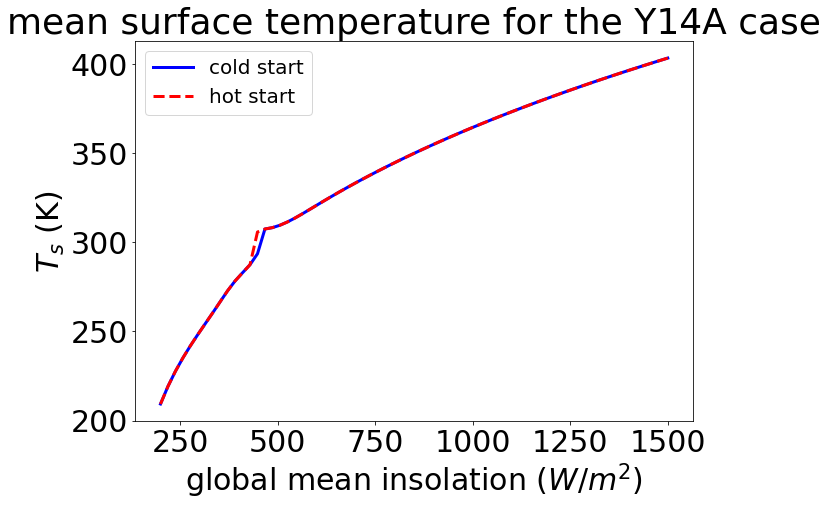

In [16]:
# Check the bifurcation for the Y14A case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, Ts_cold_Y14A, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, Ts_hot_Y14A, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'mean surface temperature for the Y14A case')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

In [23]:
# Initialize lists to store the results
dS_Tideal = []
dT_Tideal = []

# Generate T_end values
T_ideal_values = np.arange(300, 300+1, 5)
k_ideal_try = 1

for T_ideal_try in T_ideal_values:
    
    use_cold = True
    
    print(T_ideal_try)

    ## Sweep over the parameter space with a cold start

    # Calculate the solutions (the IEHZ is about 2000 W/m2)
    so = np.linspace(800, 6000, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
    nele = len(so)
    # so = np.flip(so)

    # Create an empty list to store the output
    cold_list = []
    # create a dictionary with all NaN values
    nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
                'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
                'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
                'Flux4': math.nan, 'FluxC': math.nan}

    # the starting estimate of the solutions
    initial_guess = (280,250,250,220,200,100)

    T_run = 270
    sigma = 5.67e-8

    for idx, s in enumerate(so):
    #     print(idx, s)

        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                             LW = 'feedback', SW = 'constant', TOA = 'Yang2014', overshoot = '0N2',
                             daycloud = 'default', nightcloud = 'default',\
                             vaporlimit = 373,
                             T_ideal = T_ideal_try, k_ideal = k_ideal_try,
                             p_guess=initial_guess, output = 'dict')
        
#         if s < 1600:
#             initial_guess_temp = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
#             print(initial_guess_temp)
#             save_cold = False

        if output['ier'] != 1:
#             print("No solution for the cold branch, switch to hot branch instead \n")

            T_test = ((s/2/2 - (1-k_ideal_try)*sigma*T_ideal_try**4) / sigma / k_ideal_try)**(1/4)
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

            output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                                 LW = 'feedback', SW = 'constant', TOA = 'Yang2014', overshoot = '0N2',
                                 daycloud = 'default', nightcloud = 'default',\
                                 vaporlimit = 373,
                                 T_ideal = T_ideal_try, k_ideal = k_ideal_try,
                                 p_guess=initial_guess, output = 'dict')

            if output['ier'] != 1:
#                 print("No solution for the hot branch \n")
                initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
                cold_list.append(nan_dict)
            else:      # successful for hot branch
                initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
                cold_list.append(output)          
        else:   # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)

    # Save the array for the insolation
    so_cold = so

    ## extract output values from cold_list
    T1_cold_Y14C = np.array([d['T1'] for d in cold_list])

    T4_cold_Y14C = np.array([d['T4'] for d in cold_list])
    
    T2_cold_Y14C = np.array([d['T2'] for d in cold_list])

    T3_cold_Y14C = np.array([d['T3'] for d in cold_list])
    
    fc_cold_Y14C = np.array([d['fc'] for d in cold_list])
    Fc_cold_Y14C = np.array([d['Fc'] for d in cold_list])
    
    OLR_day_cold_Y14C = np.array([d['OLR_day'] for d in cold_list])
    
    OLR_night_cold_Y14C = np.array([d['OLR_night'] for d in cold_list])

    ## Sweep over the parameter space with a hot start
    # Calculate the solutions (the IEHZ is about 2000 W/m2)
    so = np.linspace(800, 6000, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
    nele = len(so)
    so = np.flip(so)

    # Create an empty list to store the output
    hot_list = []
    # create a dictionary with all NaN values
    nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
                'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
                'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
                'Flux4': math.nan, 'FluxC': math.nan}

#     # the starting estimate of the solutions
#     initial_guess_temp = (280,250,250,220,200,100)
    initial_guess_temp = (328, 314, 314, 300, 378, 318)
    
#     initial_guess_temp = (276, 248, 248, 243, 210, 257)

#     T_test = ((s/2/2 - (1-k_ideal_try)*sigma*T_ideal_try**4) / sigma / k_ideal_try)**(1/4)
    
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

    for idx, s in enumerate(so):
            
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                             LW = 'feedback', SW = 'constant', TOA = 'Yang2014', overshoot = '0N2',
                             daycloud = 'default', nightcloud = 'default',\
                             vaporlimit = 373,
                             T_ideal = T_ideal_try, k_ideal = k_ideal_try,
                             p_guess=initial_guess, output = 'dict')
        
#         # special treatment to avoid negative solution
#         if output['T1'] < 0 and use_cold == True:
#             initial_guess = initial_guess_temp
#             output = robust_func(So = s, epsl0 = 0.5, a0 = 0, 
#                      LW = 'Yang2014', SW = 'constant', TOA = 'Yang2014', overshoot = '0N2',
#                      daycloud = 'default', nightcloud = 'default',\
#                     vaporlimit = 1e6,
#                      T_ideal = T_ideal_try, k_ideal = k_ideal_try,
#                      p_guess=initial_guess, output = 'dict')            
#             use_cold = False

        if output['ier'] != 1:
#             print("No solution for the hot branch, switch to cold branch instead \n")
            initial_guess = initial_guess_temp

            output = main_func(So = s, epsl0 = 0.5, a0 = 0,
                                 LW = 'feedback', SW = 'constant', TOA = 'Yang2014', overshoot = '0N2',
                                 daycloud = 'default', nightcloud = 'default',\
                                 vaporlimit = 373,
                                 T_ideal = T_ideal_try, k_ideal = k_ideal_try,
                                 p_guess=initial_guess, output = 'dict')        

            if output['ier'] != 1:
#                 print("No solution for the cold branch \n")
                initial_guess = (280,250,250,220,200,100)
                hot_list.append(nan_dict)
            else:      # successful for cold branch
                initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
                hot_list.append(output)                          
        else:   # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)

    ## Save the array for the insolation
    so_hot = so

    ## extract output values from hot_list
    T1_hot_Y14C = np.array([d['T1'] for d in hot_list])

    T4_hot_Y14C = np.array([d['T4'] for d in hot_list])
    
    T2_hot_Y14C = np.array([d['T2'] for d in hot_list])

    T3_hot_Y14C = np.array([d['T3'] for d in hot_list])
    
    fc_hot_Y14C = np.array([d['fc'] for d in hot_list])
    Fc_hot_Y14C = np.array([d['Fc'] for d in hot_list])
    
    OLR_day_hot_Y14C = np.array([d['OLR_day'] for d in hot_list])
    
    OLR_night_hot_Y14C = np.array([d['OLR_night'] for d in hot_list])

    Ts_cold_Y14C = (T1_cold_Y14C+T4_cold_Y14C)/2
    Ts_hot_Y14C = (T1_hot_Y14C+T4_hot_Y14C)/2
    
    OLR_cold_Y14C = (OLR_day_cold_Y14C+OLR_night_cold_Y14C)/2
    OLR_hot_Y14C = (OLR_day_hot_Y14C+OLR_night_hot_Y14C)/2

#     dT, dS =  bifurcation(so_cold/4, Ts_cold, Ts_hot)
#     dS_Tideal.append(dS)  # Append the output to dS_values list
#     dT_Tideal.append(dT)  # Append the output to dT_values list
    

300


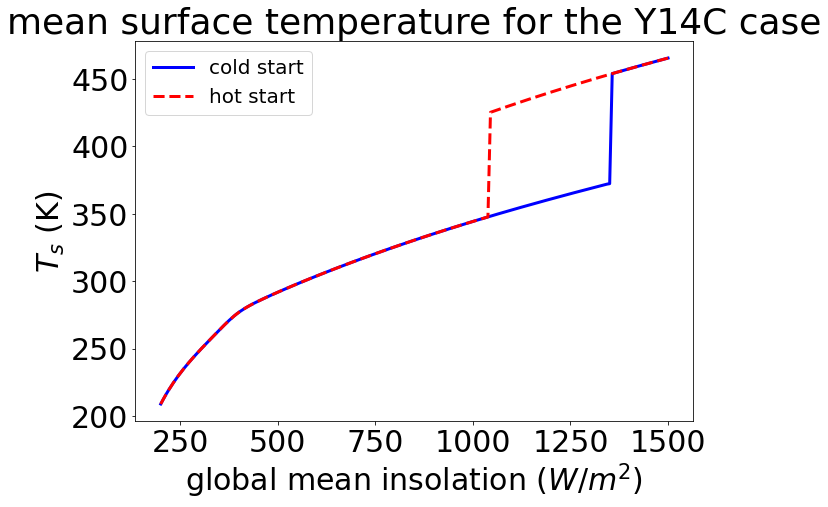

In [19]:
# Check the bifurcation for the Y14A case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, Ts_cold_Y14C, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, Ts_hot_Y14C, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'mean surface temperature for the Y14C case')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

In [20]:
### Baseline case: with dayside cloud, no nightside cloud, runaway greenhouse, SW absorption, water vapor atmosphere

## Sweep over the parameter space with a cold start

# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 6000, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
# so = np.flip(so)

# Create an empty list to store the output
cold_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8

for idx, s in enumerate(so):
#     print(idx, s)
    
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'feedback', SW = 'feedback', TOA = 'runaway', overshoot = '0N2',\
                           daycloud = 'default', nightcloud = 'default',\
                           vaporlimit = 373,
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the cold branch, switch to hot branch instead \n")
        
        T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
        initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'feedback', SW = 'feedback', TOA = 'runaway', overshoot = '0N2',\
                           daycloud = 'default', nightcloud = 'default',\
                           vaporlimit = 373,
                           p_guess=initial_guess, output = 'dict')
        
        if output['ier'] != 1:
            print("No solution for the hot branch \n")
            initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
            cold_list.append(nan_dict)
        else:      # successful for hot branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            cold_list.append(output)
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for cold branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        cold_list.append(output)

# Save the array for the insolation
so_cold = so

## extract output values from cold_list
T1_cold = np.array([d['T1'] for d in cold_list])

T2_cold = np.array([d['T2'] for d in cold_list])

T3_cold = np.array([d['T3'] for d in cold_list])

T4_cold = np.array([d['T4'] for d in cold_list])

Fa_cold = np.array([d['Fa'] for d in cold_list])

Fc_cold = np.array([d['Fc'] for d in cold_list])

fc_cold = np.array([d['fc'] for d in cold_list])

ap_cold = np.array([d['alpha_p'] for d in cold_list])

ab_cold = np.array([d['alpha_b'] for d in cold_list])

OLR_cold_day = np.array([d['OLR_day'] for d in cold_list])

OLR_cold_night = np.array([d['OLR_night'] for d in cold_list])

a2_cold = np.array([d['a_2'] for d in cold_list])

e2_cold = np.array([d['epsl_2'] for d in cold_list])

## Sweep over the parameter space with a hot start
# Calculate the solutions (the IEHZ is about 2000 W/m2)
so = np.linspace(800, 6000, 34*2+1)  # vary solar forcing from 800 to 2800 W/m2
nele = len(so)
so = np.flip(so)

# Create an empty list to store the output
hot_list = []
# create a dictionary with all NaN values
nan_dict = {'T1': math.nan, 'T2': math.nan, 'T3': math.nan, 'T4': math.nan, 'Fa': math.nan, 'Fc': math.nan, 'fc': math.nan, 
            'q1': math.nan, 'q2': math.nan, 'q3': math.nan, 'alpha_p': math.nan, 'alpha_b': math.nan, 'epsl_2': math.nan, 'epsl_3': math.nan, 
            'a_2': math.nan, 'OLR_day': math.nan, 'OLR_night': math.nan, 'Flux1': math.nan, 'Flux2': math.nan, 'Flux3': math.nan, 
            'Flux4': math.nan, 'FluxC': math.nan}

# the starting estimate of the solutions
initial_guess_temp = (280,250,250,220,200,100)
# initial_guess = (328, 314, 314, 300, 378, 318)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, \
#                  477.75002024925897, -1.596843162805312)
# initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, \
#                  378.90927762308166, 318.1347994089153)

T_run = 270
sigma = 5.67e-8
T_test = abs(((max(so)/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
initial_guess = (T_test, T_test, T_test, T_test, 0, 0)

for idx, s in enumerate(so):
#     print(idx, s)
#     T_test = abs(((s/2/2-sigma*T_run**4)/2/5.67e-3))**(1/2) + 850
#     initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
    output = main_func(So = s, epsl0 = 0.5, a0 = 0, \
                           LW = 'feedback', SW = 'feedback', TOA = 'runaway', overshoot = '0N2',\
                           daycloud = 'default', nightcloud = 'default',\
                           vaporlimit = 373,
                           p_guess=initial_guess, output = 'dict')
    
    if output['ier'] != 1:
        print("No solution for the hot branch, switch to cold branch instead \n")
        initial_guess = initial_guess_temp
        
        output = main_func(So = s, epsl0 = 0.5, a0 = 0, 
                               LW = 'feedback', SW = 'feedback', TOA = 'runaway',overshoot = '0N2',
                               daycloud = 'default', nightcloud = 'default',
                               vaporlimit = 373,
                               p_guess=initial_guess, output = 'dict')        
        
        if output['ier'] != 1:
            print("No solution for the cold branch \n")
            initial_guess = (280,250,250,220,200,100)
            hot_list.append(nan_dict)
        else:      # successful for cold branch
            initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
            hot_list.append(output)               
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
#         initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)
#         initial_guess = (T_test, T_test, T_test, T_test, 0, 0)
#         cold_list.append(nan_dict)             
    else:   # successful for hot branch
        # with a set of solutions
#         initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        initial_guess = (output['T1'],output['T2'],output['T3'],output['T4'],output['Fa'],output['Fc'])
        hot_list.append(output)

## Save the array for the insolation
so_hot = so

## extract output values from hot_list
T1_hot = np.array([d['T1'] for d in hot_list])

T2_hot = np.array([d['T2'] for d in hot_list])

T3_hot = np.array([d['T3'] for d in hot_list])

T4_hot = np.array([d['T4'] for d in hot_list])

Fa_hot = np.array([d['Fa'] for d in hot_list])

Fc_hot = np.array([d['Fc'] for d in hot_list])

fc_hot = np.array([d['fc'] for d in hot_list])

ap_hot = np.array([d['alpha_p'] for d in hot_list])

ab_hot = np.array([d['alpha_b'] for d in hot_list])

OLR_hot_day = np.array([d['OLR_day'] for d in hot_list])

OLR_hot_night = np.array([d['OLR_night'] for d in hot_list])

e2_hot = np.array([d['epsl_2'] for d in hot_list])

a2_hot = np.array([d['a_2'] for d in hot_list])

Ts_cold_base = (T1_cold+T4_cold)/2
Ts_hot_base = (T1_hot+T4_hot)/2
OLR_cold_base = (OLR_cold_day + OLR_cold_night) / 2
OLR_hot_base = (OLR_hot_day + OLR_hot_night) / 2
abs_cold_base = (1 - ap_cold) * (a2_cold)
abs_hot_base = (1 - ap_hot) * (a2_hot)

Fa_cold = np.array([d['Fa'] for d in cold_list])
Fc_cold = np.array([d['Fc'] for d in cold_list])
Fa_hot = np.array([d['Fa'] for d in hot_list])
Fc_hot = np.array([d['Fc'] for d in hot_list])
RC_cold_base = Fc_cold - 0.2 * Fa_cold
RC_hot_base = Fc_hot - 0.2 * Fa_hot
sigma = 5.67e-8
Tc = 230
CRE_cold_base = fc_cold * (sigma * T1_cold**4 - e2_cold*sigma*T1_cold**4 + e2_cold*sigma*T2_cold**4 - 2*sigma*Tc**4)
CRE_hot_base = fc_hot * (sigma * T1_hot**4 - e2_hot*sigma*T1_hot**4 + e2_hot*sigma*T2_hot**4 - 2*sigma*Tc**4)

No solution for the cold branch, switch to hot branch instead 

No solution for the hot branch, switch to cold branch instead 



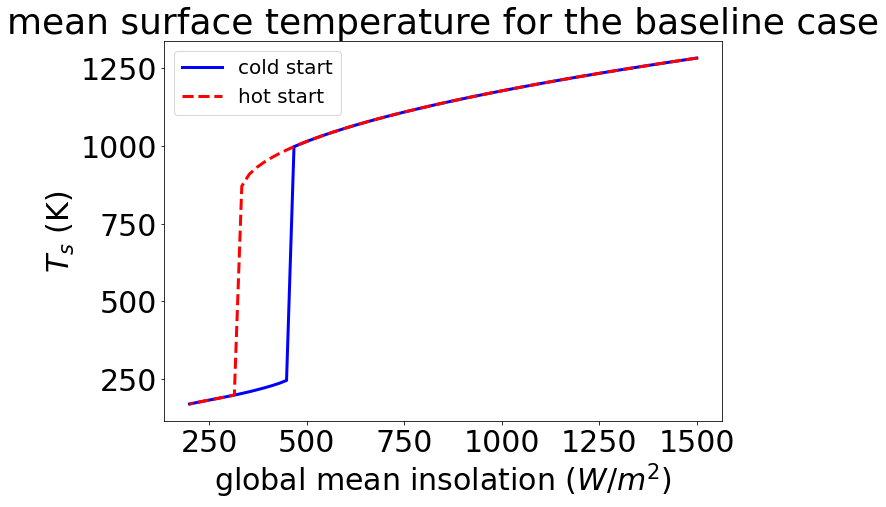

In [21]:
# Check the bifurcation for the baseline case
def plot_abs(): 
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax.plot(so_cold/4, Ts_cold_base, '-', color = 'blue',linewidth=3, label = r'cold start')
    ax.plot(so_hot/4, Ts_hot_base, '--', color = 'red', linewidth=3, label = r'hot start')
    ax.set_ylabel(r'$T_s$ (K)')
    ax.set_xlabel(r'global mean insolation ($W/m^2$)')
    ax.set_title(r'mean surface temperature for the baseline case')
    ax.legend(loc = 'upper left',fontsize=20,)
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs()
# print(min(OLR_cold_day - np.flip(OLR_hot_day)))

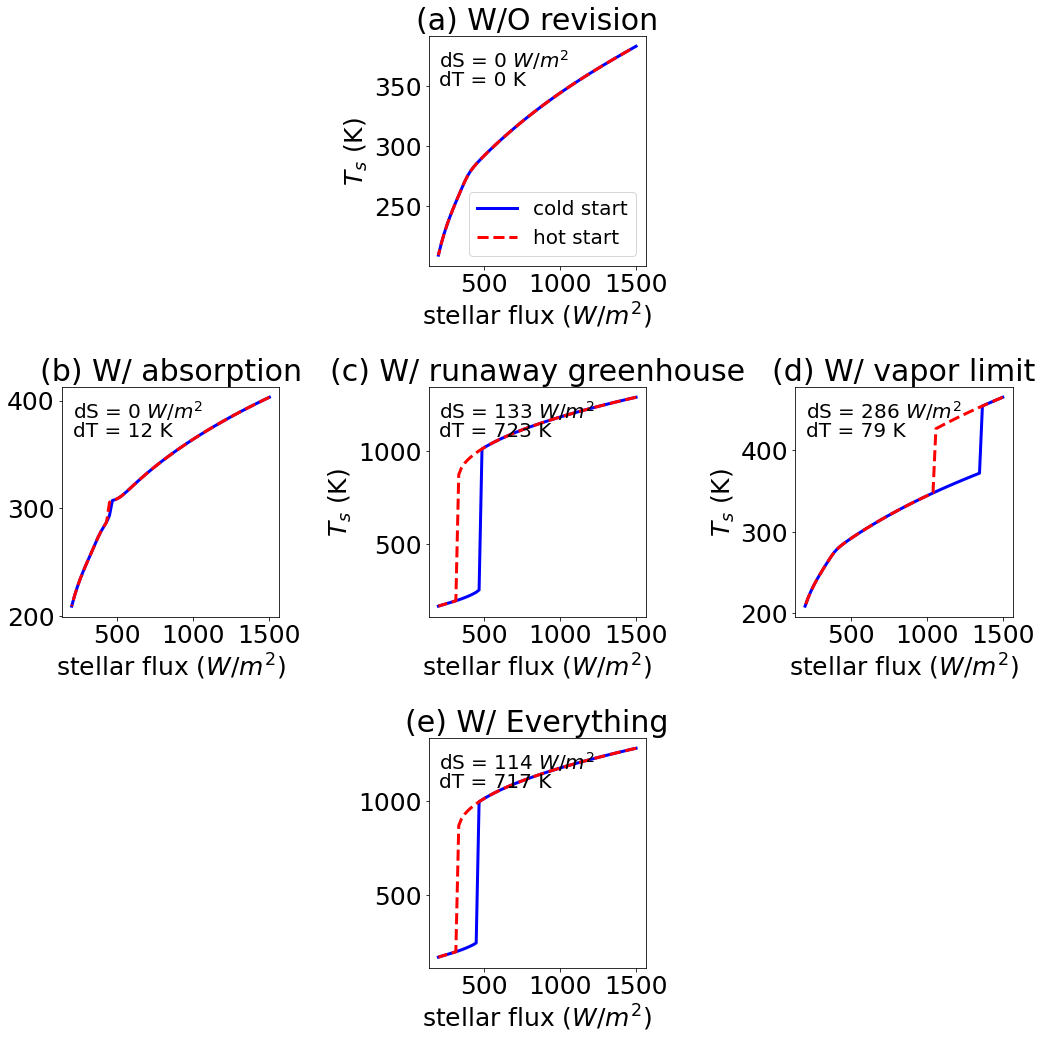

In [30]:
import matplotlib.gridspec as gridspec

# Check the bifurcation for the NCR case
def bifurcation(so, Ts_cold0, Ts_hot0): 
    
    Ts_cold = Ts_cold0
    Ts_hot = np.flip(Ts_hot0)
    
    # Find where the difference is greater than 10
    condition = Ts_hot - Ts_cold > 10

    # Extract the indices where the condition is True
    indices = np.where(condition)[0]
    
    if indices.size == 0:
        return 0, 0
    else:
        dT = sum(Ts_hot[indices]-Ts_cold[indices]) / len(Ts_hot[indices])
        dS = np.max(so[indices]) - np.min(so[indices])        
    return dT,dS

# Create a figure
fig = plt.figure(figsize=(15, 15))
plt.rc('font', size = 25)

# Define the grid layout
gs = gridspec.GridSpec(3, 3)  # 2 rows, 6 columns to allow centering

# Create subplots
# First row, centered panels
ax1 = fig.add_subplot(gs[0, 1])  # Spans from the second to the third column
ax2 = fig.add_subplot(gs[1, 0])  # Spans from the fourth to the fifth column
ax3 = fig.add_subplot(gs[1, 1])  # Spans from the second to the third column
ax4 = fig.add_subplot(gs[1, 2])  # Spans from the fourth to the fifth column
ax5 = fig.add_subplot(gs[2, 1])  # Spans from the fourth to the fifth column

ax1.plot(so_cold/4, Ts_cold_Yang2014, '-', color = 'blue',linewidth=3, label = r'cold start')
ax1.plot(so_hot/4, Ts_hot_Yang2014, '--', color = 'red', linewidth=3, label = r'hot start')
ax1.set_ylabel(r'$T_s$ (K)')
ax1.set_xlabel(r'stellar flux ($W/m^2$)')
ax1.set_title(r'(a) W/O revision')
#     ax2.legend(loc = 'upper left',fontsize=20,)
ax1.legend(loc = 'lower right',fontsize=20)
dT, ds =  bifurcation(so_cold/4, Ts_cold_Yang2014, Ts_hot_Yang2014)
ax1.text(0.05, 0.95, f'dS = {int(ds)} $W/m^2$', transform=ax1.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax1.text(0.05, 0.85, f'dT = {int(dT)} K', transform=ax1.transAxes, ha='left', va='top', fontsize=20)  # Text for B

ax2.plot(so_cold/4, Ts_cold_Y14A, '-', color = 'blue',linewidth=3)
ax2.plot(so_hot/4, Ts_hot_Y14A, '--', color = 'red', linewidth=3)
# ax4.set_ylabel(r'$T_s$ (K)')
ax2.set_xlabel(r'stellar flux ($W/m^2$)')
ax2.set_title(r'(b) W/ absorption')
#     ax4.legend(loc = 'upper left',fontsize=20,)
dT, ds =  bifurcation(so_cold/4, Ts_cold_Y14A, Ts_hot_Y14A)
ax2.text(0.05, 0.95, f'dS = {int(ds)} $W/m^2$', transform=ax2.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax2.text(0.05, 0.85, f'dT = {int(dT)} K', transform=ax2.transAxes, ha='left', va='top', fontsize=20)  # Text for B
    
ax3.plot(so_cold/4, Ts_cold_Y14R, '-', color = 'blue',linewidth=3)
ax3.plot(so_hot/4, Ts_hot_Y14R, '--', color = 'red', linewidth=3)
ax3.set_ylabel(r'$T_s$ (K)')
ax3.set_xlabel(r'stellar flux ($W/m^2$)')
ax3.set_title(r'(c) W/ runaway greenhouse')
#     ax3.legend(loc = 'upper left',fontsize=20,)
dT, ds =  bifurcation(so_cold/4, Ts_cold_Y14R, Ts_hot_Y14R)
ax3.text(0.05, 0.95, f'dS = {int(ds)} $W/m^2$', transform=ax3.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax3.text(0.05, 0.85, f'dT = {int(dT)} K', transform=ax3.transAxes, ha='left', va='top', fontsize=20)  # Text for B

ax4.plot(so_cold/4, Ts_cold_Y14C, '-', color = 'blue',linewidth=3)
ax4.plot(so_hot/4, Ts_hot_Y14C, '--', color = 'red', linewidth=3)
ax4.set_ylabel(r'$T_s$ (K)')
ax4.set_xlabel(r'stellar flux ($W/m^2$)')
ax4.set_title(r'(d) W/ vapor limit')
#     ax3.legend(loc = 'upper left',fontsize=20,)
dT, ds =  bifurcation(so_cold/4, Ts_cold_Y14C, Ts_hot_Y14C)
ax4.text(0.05, 0.95, f'dS = {int(ds)} $W/m^2$', transform=ax4.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax4.text(0.05, 0.85, f'dT = {int(dT)} K', transform=ax4.transAxes, ha='left', va='top', fontsize=20)  # Text for B

ax5.plot(so_cold/4, Ts_cold_base, '-', color = 'blue',linewidth=3)
ax5.plot(so_hot/4, Ts_hot_base, '--', color = 'red', linewidth=3)

ax5.set_xlabel(r'stellar flux ($W/m^2$)')
ax5.set_title(r'(e) W/ Everything')
dT, ds =  bifurcation(so_cold/4, Ts_cold_base, Ts_hot_base)
ax5.text(0.05, 0.95, f'dS = {int(ds)} $W/m^2$', transform=ax5.transAxes, ha='left', va='top', fontsize=20)  # Text for A
ax5.text(0.05, 0.85, f'dT = {int(dT)} K', transform=ax5.transAxes, ha='left', va='top', fontsize=20)  # Text for B

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()